In [1]:
from utils import *
from matplotlib import patches
from matplotlib import rcParams
from scipy import stats
import pandas as pd
import random
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources, deblend_sources
from astropy.table import Table, Column, setdiff, join, unique

rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 15})
rcParams.update({'font.serif': 'Times New Roman'})

In [2]:
hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
data = hdu.data #-np.median(hdu.data)

# Runned from create_photometric_light_APASS 
seg_map = fits.open("./SE_APASS/coadd_SloanR_NGC_5907_seg.fits")[0].data
weight_edge_map = fits.open("./weight_NGC5907.fits")[0].data
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor")

seeing = 2.5
header = hdu.header
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5750                                                  
NAXIS2  =                 4250                                                  
CTYPE1  = 'RA---TAN'                                                            
CRPIX1  =               2875.5                                                  
CRVAL1  =              228.975                                                  
CTYPE2  = 'DEC--TAN'                                                            
CRPIX2  =               2125.5                                                  
CRVAL2  =       56.32916666667                                                  
CD1_1   =  -0.0006944444444444                                                  
CD1_2   =                  0

mu: 884.42 , std: 4.96 , ZP: 27.10 , pix_scale: 2.50


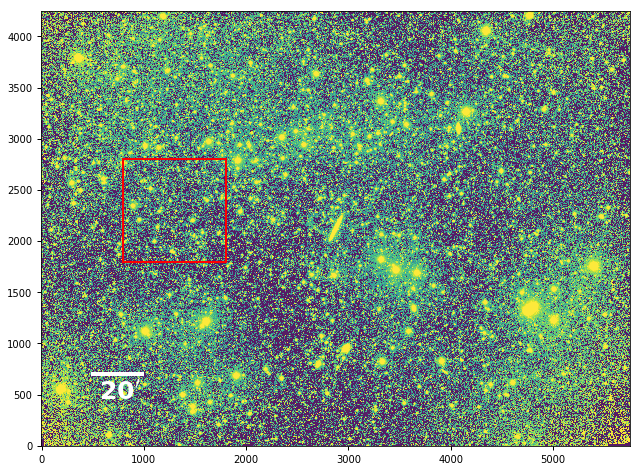

In [3]:
mu, std, = np.float(hdu.header["BACKVAL"]), mad_std(hdu.data[seg_map==0&(weight_edge_map>0.5)]) 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = 800, 1800, 1800, 2800  # image coords
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = 2500, 500, 3500, 1500  # image coords

image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)

def crop_image(data, seg_map, bounds, weight_map=None, draw=False):
    patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = bounds
    patch_xmin, patch_ymin = coord_Im2Array(patch_Xmin, patch_Ymin)
    patch_xmax, patch_ymax = coord_Im2Array(patch_Xmax, patch_Ymax)

    patch = np.copy(data[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    seg_patch = np.copy(seg_map[patch_xmin:patch_xmax, patch_ymin:patch_ymax])
    
    if draw:
        fig, ax = plt.subplots(figsize=(12,8))       
        plt.imshow(data, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis",alpha=0.9)
        if weight_map is not None:
            plt.imshow(data*weight_map, vmin=mu, vmax=mu+10*std, norm=norm1, origin="lower", cmap="viridis",alpha=0.3)
        plt.plot([500,980],[700,700],"w",lw=4)
        plt.text(560,450, r"$\bf 20'$",color='w', fontsize=25)
        rect = patches.Rectangle((patch_Xmin,patch_Ymin), bounds[2]-bounds[0], bounds[3]-bounds[1],
                                 linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
    return patch, seg_patch

patch, seg_patch = crop_image(data, seg_map, image_bounds, draw=True)

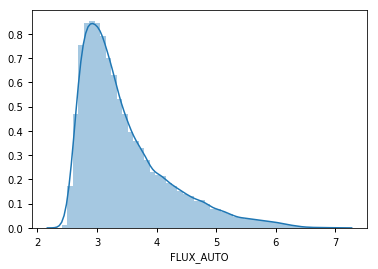

In [4]:
import seaborn as sns
sns.distplot(np.log10(SE_cat_full[(SE_cat_full["FLAGS"]<8)]["FLUX_AUTO"]))
SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
SE_cat = crop_catalog(SE_cat_full, bounds)

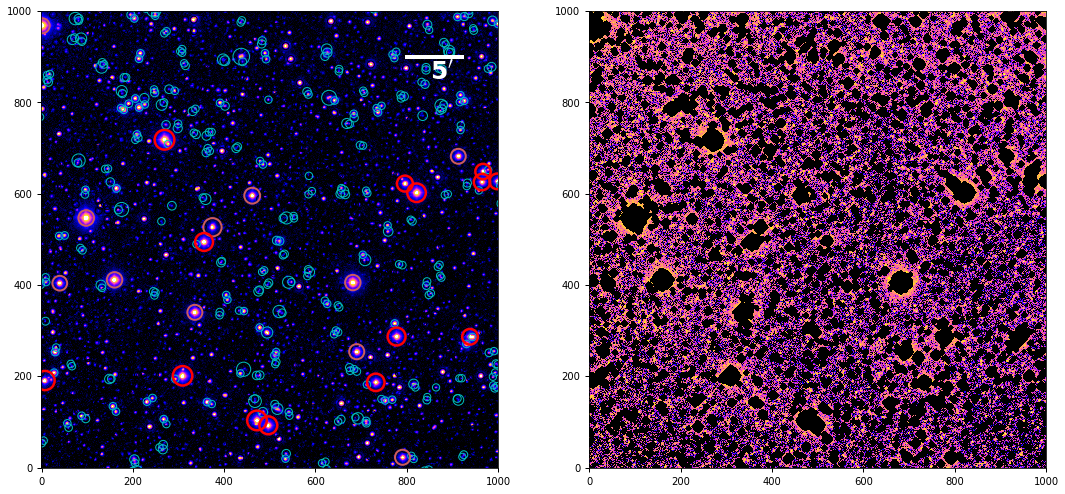

In [5]:
star = SE_cat[(SE_cat["FLAGS"]==0)|(SE_cat["FLAGS"]==1)]
star_BLEND = SE_cat[(SE_cat["FLAGS"]==2)|(SE_cat["FLAGS"]==3)]
star_SATURATE = SE_cat[(SE_cat["FLAGS"]==4)|(SE_cat["FLAGS"]==5)]
star_SATBLEND = SE_cat[(SE_cat["FLAGS"]==6)|(SE_cat["FLAGS"]==7)]

plt.figure(figsize=(18,9))
ax = plt.subplot(121)
plt.scatter(star["X_IMAGE"]-patch_Xmin, star["Y_IMAGE"]-patch_Ymin, 
            s=50, edgecolors="k",facecolors="None")
plt.scatter(star_BLEND["X_IMAGE"]-patch_Xmin, star_BLEND["Y_IMAGE"]-patch_Ymin, 
            s=star_BLEND["FWHM_IMAGE"]*20, lw=1., edgecolors="c",facecolors="None")
plt.scatter(star_SATURATE["X_IMAGE"]-patch_Xmin, star_SATURATE["Y_IMAGE"]-patch_Ymin, 
            s=star_BLEND["FWHM_IMAGE"]*80, lw=2., edgecolors="indianred",facecolors="None")
plt.scatter(star_SATBLEND["X_IMAGE"]-patch_Xmin, star_SATBLEND["Y_IMAGE"]-patch_Ymin, 
            s=star_SATBLEND["FWHM_IMAGE"]*80, lw=2.5, edgecolors="r",facecolors="None")
plt.plot([800,920],[900,900],"w",lw=4)
plt.text(850,850,r"$\bf 5'$", color='w',fontsize=25)
plt.imshow(patch, vmin=mu-1, vmax=1e4, 
           norm=norm1, origin="lower", cmap="gnuplot2")

ax = plt.subplot(122)
patch2 = patch.copy()
seg_patch2 = seg_patch.copy()
for i in range(5):
    seg_patch2 = morphology.dilation(seg_patch2)
patch2[seg_patch2!=0] = 0
plt.imshow(patch2, vmin=mu-1, vmax=mu+10*std, norm=norm2, origin="lower", cmap="gnuplot2")

In [6]:
def get_star_pos(id, star_cat, ref_pos=(0,0)):
    X_c, Y_c = star_cat[id]["X_IMAGE"]-ref_pos[0], star_cat[id]["Y_IMAGE"]-ref_pos[1]
    return (X_c, Y_c)

def get_star_thumb(id, star_cat, data=data, seg_map=seg_map, n_win=15,
                   ref_pos=(0,0), seeing=2.5, header=hdu.header, verbose=True):
    (X_c, Y_c) = get_star_pos(id, star_cat, ref_pos=ref_pos)    
    fwhm =  max(star_cat[id]["FWHM_IMAGE"], seeing)
    win_size = int( n_win * min(max(fwhm,2), 8))
    X_min, X_max = X_c - win_size, X_c + win_size
    Y_min, Y_max = Y_c - win_size, Y_c + win_size
    x_min, y_min = coord_Im2Array(X_min, Y_min)
    x_max, y_max = coord_Im2Array(X_max, Y_max)
    
    if verbose:
        num = star_cat[id]["NUMBER"]
        print("NUMBER: ",num)
        print("X_c, Y_c: ", (X_c, Y_c))
        print("x_min, x_max, y_min, y_max: ", x_min, x_max, y_min, y_max)
    
    img_thumb = data[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max].copy()
    seg_thumb = seg_map[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max]
    mask_thumb = (seg_thumb!=0)    
    
    w = wcs.WCS(header)
    X_cen, Y_cen = w.wcs_world2pix(star_cat[id]["X_WORLD"], star_cat[id]["Y_WORLD"], 1)
    cen_star = X_cen - (y_min+1), Y_cen - (x_min+1)
    
    return img_thumb, seg_thumb, mask_thumb, cen_star

def display_star(id, star_cat, data=data, seg_map=seg_map, ref_pos=(0,0), enlarge_mask=3):
    img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data, seg_map, ref_pos=ref_pos)
    
    mask_thumb0 = mask_thumb.copy()
    for i in range(enlarge_mask):
        mask_thumb = morphology.dilation(mask_thumb)
        
    img_thumb[mask_thumb] = 0
    img_thumb[mask_thumb0] = np.nan
    
    plt.figure(figsize=(10,8))
    plt.imshow(img_thumb, vmin=882, vmax=1000, norm=norm1, origin="lower", cmap="viridis")
    plt.colorbar()
    plt.show() 
    
def extract_star(id, star_cat, data=data, seg_map=seg_map, 
                 seeing=2.5, sn_thre=2., n_win=20,
                 display_bg=False, display=True, verbose=False):
    
    img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data=data, seg_map=seg_map,
                                                                n_win=n_win, seeing=seeing, verbose=verbose)
    fwhm = max([star_cat[id]["FWHM_IMAGE"], seeing])

    b_size = round(img_thumb.shape[0]//5/25)*25
    if img_thumb.shape[0] > 50:
        back, back_rms = background_sub_SE(img_thumb, b_size=b_size)
    else:
        back, back_rms = (np.median(img_thumb[~mask_thumb])*np.ones_like(img_thumb), 
                            mad_std(img_thumb[~mask_thumb])*np.ones_like(img_thumb))
    if display_bg:
            display_background_sub(img_thumb, back)        
    # do segmentation (second time, target-based)
    sigma = seeing * gaussian_fwhm_to_sigma
    threshold = back + (sn_thre * back_rms)
    segm = detect_sources(img_thumb, threshold, npixels=5)
    
    # deblending
    segm_deblend = deblend_sources(img_thumb, segm, npixels=5,
                                   nlevels=64,
                                   contrast=0.005)
    star_lab = segm_deblend.data[img_thumb.shape[0]//2, img_thumb.shape[1]//2]
    star_ma = ~((segm_deblend.data==star_lab) | (segm_deblend.data==0)) # mask other source
    
    # display
    if display:
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(21,5))
        ax1.imshow(img_thumb, vmin=np.median(back)-1, vmax=10000, norm=norm1, origin="lower", cmap="viridis")
        ax1.set_title("star", fontsize=15)
        ax2.imshow(segm, origin="lower", cmap=segm.make_cmap(random_state=12345))
        ax2.set_title("segment", fontsize=15)
        ax3.imshow(segm_deblend, origin="lower", cmap=segm_deblend.make_cmap(random_state=12345))
        ax3.set_title("deblend", fontsize=15)

        img_thumb_ma = img_thumb.copy()
        img_thumb_ma[star_ma] = -1
        ax4.imshow(img_thumb_ma, origin="lower", cmap="viridis", 
                   vmin=np.median(back)-1, vmax=np.median(back)+10*np.median(back_rms), norm=norm2)
        ax4.set_title("extracted star", fontsize=15)
    
    return img_thumb, star_ma, back, cen_star

NUMBER:  30008
X_c, Y_c:  (1613.1324, 1220.0507)
x_min, x_max, y_min, y_max:  927 1511 1320 1904


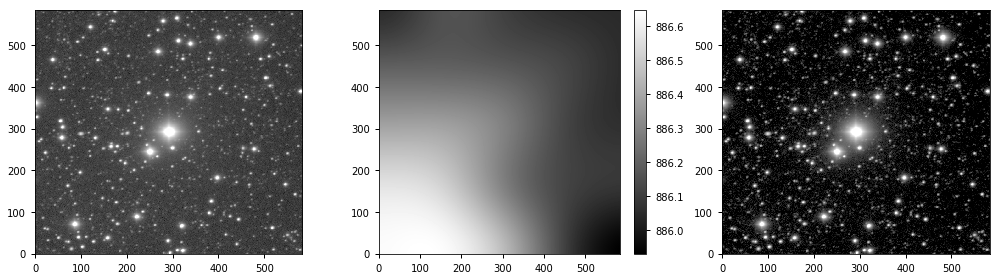

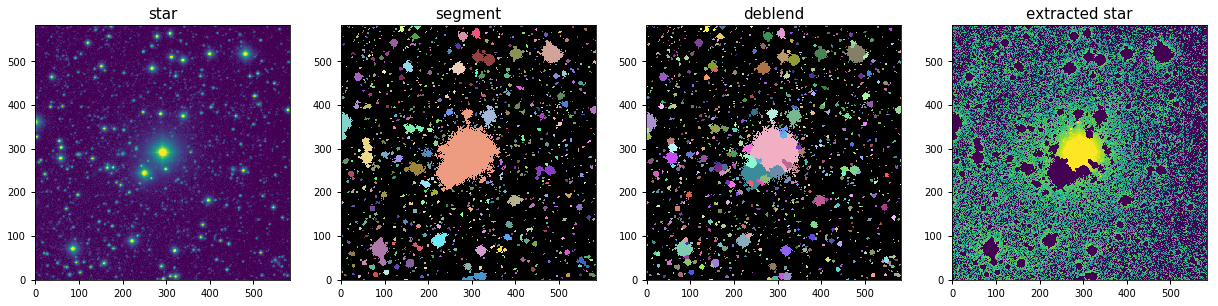

In [132]:
num = 30008
id = num-1
star_thumb0, star_ma0, star_back0, cen_star0 = extract_star(id, SE_cat_full, n_win=40, display_bg=True, display=True, verbose=True)

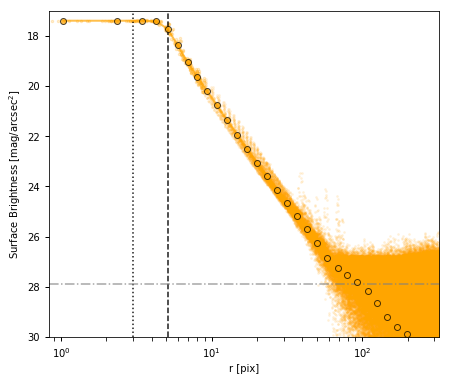

In [133]:
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(star_thumb0, cen=cen_star0, mask=star_ma0,
                                             ZP=ZP, sky_mean=np.median(star_back0), sky_std=3, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="orange",
                                             core_undersample=False, scatter=True, plot_line=True)

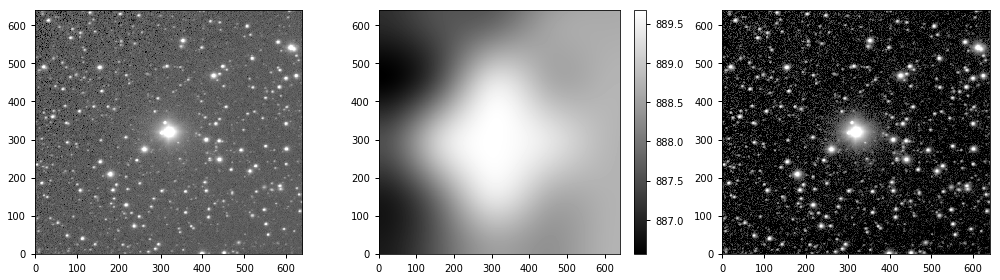

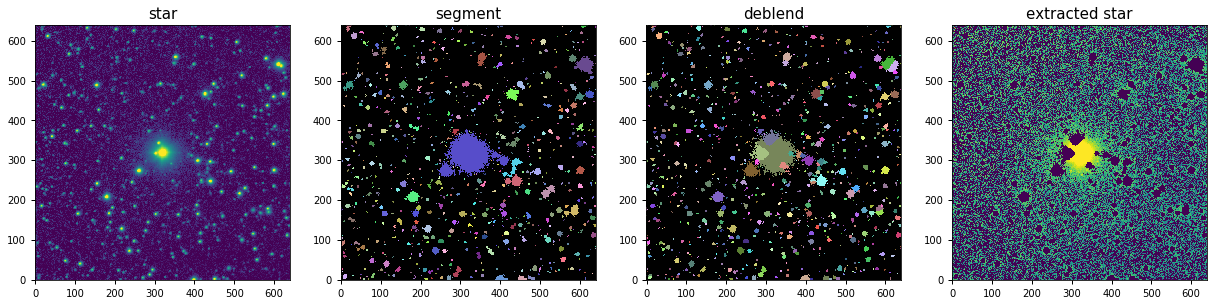

In [155]:
num = SE_cat_full[SE_cat_full["FLUX_AUTO"].argmax()]["NUMBER"]
id = num-1
star_thumb1, star_ma1, star_back1, cen_star1 = extract_star(id, SE_cat_full, n_win=40, display_bg=True, display=True)

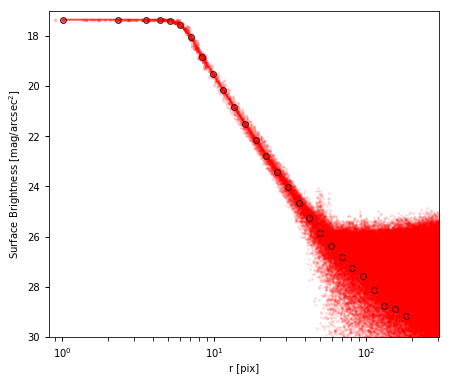

In [157]:
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(star_thumb1, cen=cen_star1, mask=star_ma1, 
                                             ZP=ZP, sky_mean=np.median(star_back1), sky_std=std,
                                             xunit="pix", yunit="SB", color="r", scatter=True, plot_line=False)
plt.xscale("log")

## Normalization

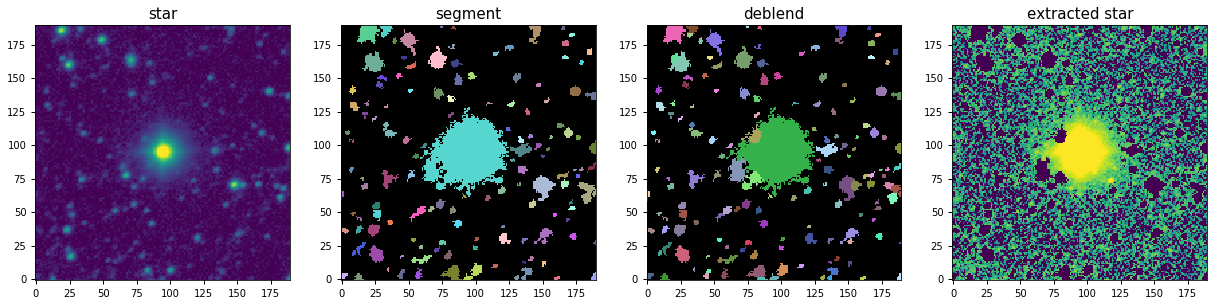

In [153]:
num = 18840
id = num-1
star_thumb2, star_ma2, star_back2, cen_star2 = extract_star(id, SE_cat_full, display_bg=False, display=True)

<Row index=35501>
NUMBER FLUX_AUTO FLUXERR_AUTO  X_IMAGE   Y_IMAGE    X_WORLD      Y_WORLD    ELLIPTICITY FWHM_IMAGE KRON_RADIUS THETA_IMAGE     MU_MAX    FLAGS CLASS_STAR     RMAG_AUTO     
           ct         ct         pix       pix        deg          deg                     pix                     deg     mag / arcsec2                          ct        
int64   float64    float64     float64   float64    float64      float64      float64    float64     float64     float64      float64    int64  float64        float64      
------ --------- ------------ --------- --------- ------------ ------------ ----------- ---------- ----------- ----------- ------------- ----- ---------- ------------------
 35502  635834.7     745.9388 3584.3564 3566.8882 228.06328186 57.326732574       0.061        3.1         3.5       53.33       -9.4841     6       0.81 12.587793427915429

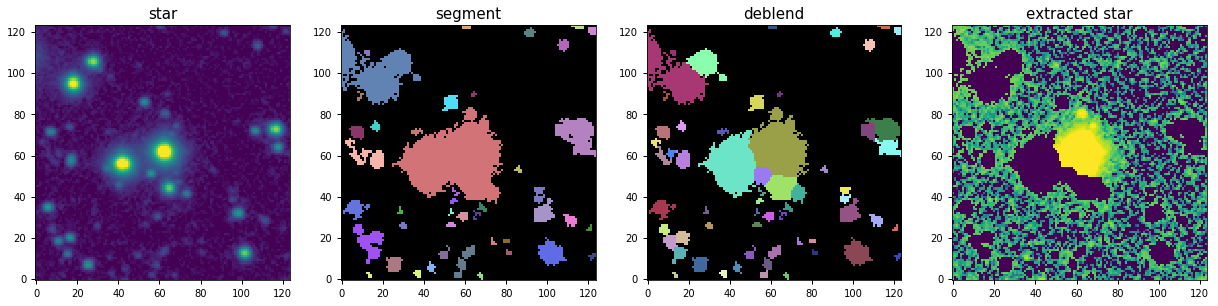

In [154]:
num = 35502
id = num-1
star_thumb3, star_ma3, star_back3, cen_star3 = extract_star(id, SE_cat_full, display_bg=False, display=True)
SE_cat_full[id]

<Row index=19492>
NUMBER FLUX_AUTO FLUXERR_AUTO  X_IMAGE   Y_IMAGE    X_WORLD      Y_WORLD   ELLIPTICITY FWHM_IMAGE KRON_RADIUS THETA_IMAGE     MU_MAX    FLAGS CLASS_STAR     RMAG_AUTO     
           ct         ct         pix       pix        deg          deg                    pix                     deg     mag / arcsec2                          ct        
int64   float64    float64     float64   float64    float64      float64     float64    float64     float64     float64      float64    int64  float64        float64      
------ --------- ------------ --------- --------- ------------ ----------- ----------- ---------- ----------- ----------- ------------- ----- ---------- ------------------
 19493  110085.4      312.369 1425.6667 2158.5706 230.79148511 56.33884712       0.062       2.79         3.5       19.04       -7.7626     2      0.838 14.491829679409271

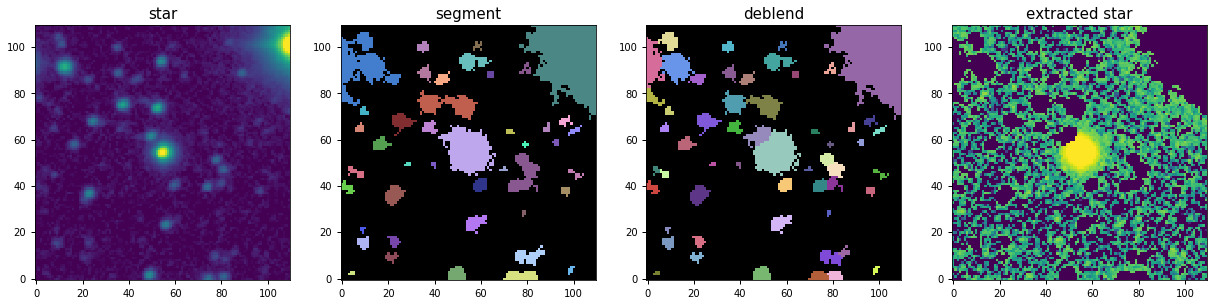

In [139]:
num = 19493
id = num-1
star_thumb4, star_ma4, star_back4, cen_star4 = extract_star(id, SE_cat_full, display_bg=False, display=True)
SE_cat_full[id] # mag~14.5

Do nomalization at r=10 pix (0.4 arcmin)

In [7]:
def compute_Rnorm(image, mask_field, cen, R=8, wid=0.5, display=False):
    """ Return sigma-clipped mean, med and std of ring r=R (half-width=wid) for image"""
    from astropy.stats import sigma_clip, SigmaClip, sigma_clipped_stats
    from photutils import CircularAperture, CircularAnnulus
    annulus = CircularAnnulus(cen, R-wid, R+wid)
    annulus_ma = annulus.to_mask()      
    mask_ring = annulus_ma.to_image(image.shape)>0.5    # sky ring (R-wid, R+wid)
    mask_clean = mask_ring & (~mask_field)            # sky ring with other sources masked
    z_mean, z_med, z_std = sigma_clipped_stats(image[mask_clean], sigma=3)
    
    if display:
        plt.imshow(mask_clean*image, origin="lower", cmap="gray", norm=norm1, vmin=z_med-5*z_std, vmax=z_med+5*z_std)
    
    return z_mean, z_med, z_std

In [158]:
y_mean0, y_med0, y_std0 = compute_Rnorm(star_thumb0, star_ma0, cen_star0, R=8, wid=0.5)
y_mean1, y_med1, y_std1 = compute_Rnorm(star_thumb1, star_ma1, cen_star1, R=8, wid=0.5)
y_mean2, y_med2, y_std2 = compute_Rnorm(star_thumb2, star_ma2, cen_star2, R=8, wid=0.5)
y_mean3, y_med3, y_std3 = compute_Rnorm(star_thumb3, star_ma3, cen_star3, R=8, wid=0.5)
y_mean4, y_med4, y_std4 = compute_Rnorm(star_thumb4, star_ma4, cen_star4, R=8, wid=0.5)

(0.5, 200)

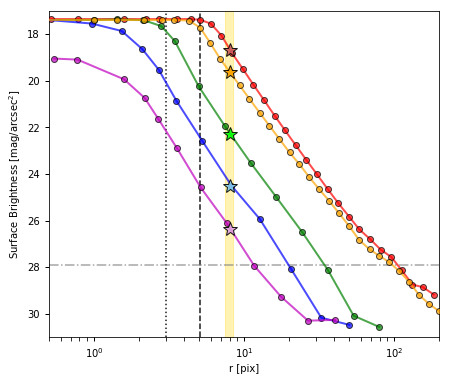

In [168]:
plt.figure(figsize=(7,6))

for img, cen, ma, bk, c in zip([star_thumb1,star_thumb2,star_thumb3,star_thumb4],
                           [cen_star1,cen_star2,cen_star3,cen_star4],
                           [star_ma1,star_ma2,star_ma3,star_ma4],
                           [star_back1,star_back2,star_back3,star_back4],
                           ["r","g","b","m"]):
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                 ZP=ZP, sky_mean=np.median(bk), sky_std=std, 
                                                 xunit="pix", yunit="SB", color=c, plot_line=False)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(star_thumb0, cen=cen_star0, mask=star_ma0, 
                                             ZP=ZP, sky_mean=np.median(star_back0), sky_std=3,
                                             xunit="pix", yunit="SB", color="orange",plot_line=True)

plt.fill_betweenx([31,17.],x1=7.5,x2=8.5, color="gold", alpha=0.3)
for y_m, y_std, c in zip([y_med1,y_med2,y_med3,y_med4],
                       [y_std1,y_std2,y_std3,y_std4],
                       ["indianred","lime","skyblue","plum"]):
    plt.plot(8,Intensity2SB(y_m, mu, ZP, pix_scale),"*", ms=15, color=c, mec='k',alpha=0.9, zorder=4)
plt.plot(8,Intensity2SB(y_med0, mu, ZP, pix_scale),"*", ms=15, color="orange", mec='k',alpha=0.9, zorder=4)
plt.xscale("log")
plt.ylim(31,17)
plt.xlim(0.5,200)

### Crossmatch

In [8]:
from astroquery.vizier import Vizier
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import re

w = wcs.WCS(header)

def query_vizier(catalog_name, radius, columns, column_filters, header=header):
    # Prepare for quearyinig Vizier with filters up to infinitely many rows. By default, this is 50.
    viz_filt = Vizier(columns=columns, column_filters=column_filters)
    viz_filt.ROW_LIMIT = -1

    RA, DEC = re.split(",", header['RADEC'])
    coords = SkyCoord(RA+" "+DEC , unit=(u.hourangle, u.deg))

    # Query!
    result = viz_filt.query_region(coords, 
                                   radius=radius, 
                                   catalog=[catalog_name])
    return result

def transform_coords2pixel(Cat, catalog_name, w=w, RA_keys="RAJ2000", DE_keys="DEJ2000"):
    coords = np.vstack([np.array(Cat[RA_keys]), 
                        np.array(Cat[DE_keys])]).T
    pos = w.wcs_world2pix(coords, 1)
    Cat.add_column(Column(np.around(pos[:,0], 4)*u.pix), name='X_IMAGE'+'_'+catalog_name)
    Cat.add_column(Column(np.around(pos[:,1], 4)*u.pix), name='Y_IMAGE'+'_'+catalog_name)
    Cat.add_column(Column(np.arange(len(Cat))+1), index=0, name="ID"+'_'+catalog_name)
    return Cat

In [9]:
result = query_vizier(catalog_name="URAT", radius=2*u.deg,
                           columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                           column_filters={'mfa':'=1', 'rmag':'{0} .. {1}'.format(8, 18)})

Cat_URAT = result['I/329/urat1']
Cat_URAT = transform_coords2pixel(Cat_URAT, "URAT")     
print("URAT Brightest Star: %.3f"%Cat_URAT["rmag"].min())
Cat_URAT

URAT Brightest Star: 10.021


<Table masked=True length=5851>
ID_URAT   RAJ2000     DEJ2000    mfa  ...  e_rmag X_IMAGE_URAT Y_IMAGE_URAT
            deg         deg           ...   mag       pix          pix     
 int64    float64     float64   int16 ... float32   float64      float64   
------- ----------- ----------- ----- ... ------- ------------ ------------
      1 231.3960886  54.8919953     1 ...   0.109     869.8167      90.2217
      2 231.4085062  54.8905875     1 ...   0.001     859.4582      88.5506
      3 231.4327147  54.9020733     1 ...   0.111     839.9942     105.7957
      4 231.5665632  54.9708164     1 ...   0.090     732.8723     208.8064
      5 231.7032039  55.0564642     1 ...   0.001     624.7972     336.4505
      6 231.6982611  55.0757669     1 ...   0.111     629.9752     364.0894
      7 229.8185033  54.4330119     1 ...   0.136    2168.6103    -601.7251
      8 229.9027283  54.4065281     1 ...   0.001     2097.512    -639.0144
      9 229.9180781  54.4184350     1 ...   0.068     2084.875    -621.6791
    ...         ...         ...   ... ...     ...          ...          ...
   5842 229.2764733  58.2954117     1 ...   0.047    2647.2176    4958.5161
   5843 229.1175294  58.2853786     1 ...   0.045    2767.5435    4943.6546
   5844 229.1435442  58.3030256     1 ...   0.001    2747.9013    4969.1416
   5845 229.1529881  58.2960219     1 ...   0.074    2740.7256    4959.0628
   5846 229.1673611  58.2909114     1 ...   0.059    2729.8216     4951.725
   5847 229.3131450  58.2856031     1 ...   0.055    2619.3795    4944.5072
   5848 229.0899040  58.3098267     1 ...   0.075    2788.5267    4978.8614
   5849 229.1264961  58.2950147     1 ...   0.041    2760.7824    4957.5616
   5850 228.1247858  58.1776383     1 ...   0.074    3521.3957    4792.2971
   5851 228.1948056  58.2227125     1 ...   0.093    3467.4667    4856.6273

In [10]:
result = query_vizier(catalog_name="USNO", radius=2*u.deg,
                           columns=['RAJ2000', 'DEJ2000', "Bmag","Rmag"],
                           column_filters={"Rmag":'{0} .. {1}'.format(5, 15)})

Cat_USNO = result['I/252/out']
Cat_USNO = transform_coords2pixel(Cat_USNO, "USNO")
print("USNO Brightest Star: %.3f"%Cat_USNO["Rmag"].min())
Cat_USNO

USNO Brightest Star: 7.000


<Table masked=True length=3566>
ID_USNO  RAJ2000    DEJ2000     Bmag    Rmag  X_IMAGE_USNO Y_IMAGE_USNO
           deg        deg       mag     mag       pix          pix     
 int64   float64    float64   float32 float32   float64      float64   
------- ---------- ---------- ------- ------- ------------ ------------
      1 225.388345  56.331025    15.8    14.4    5738.6781    2202.7836
      2 225.404284  56.174184    15.8    14.4    5737.6759    1976.4389
      3 225.410592  56.554342    15.1    14.6     5704.262    2523.1977
      4 225.413998  56.367050    12.6    10.8     5715.517    2253.5573
      5 225.416437  56.132287    14.3    13.0    5731.0556    1915.6474
      6 225.418828  56.699717    15.5    14.9    5686.9072    2732.0469
      7 225.427314  56.608798    14.3    13.5    5686.9495    2600.8696
      8 225.443048  56.097173    14.7    14.0    5712.2992    1864.0215
      9 225.458848  56.392448    15.0    14.3    5677.8823    2288.2634
    ...        ...        ...     ...     ...          ...          ...
   3557 232.466712  55.972312    15.4    14.9      61.8938    1682.6989
   3558 232.467214  56.721720    15.7    14.7     116.2588    2761.1086
   3559 232.479048  56.149073    14.8    14.4      64.9167    1937.5622
   3560 232.487537  56.492523    13.0    12.5      83.3549    2432.1198
   3561 232.488237  56.549092    13.5    12.8      86.9577     2513.549
   3562 232.496564  56.183114    16.9    15.0      53.3773     1987.262
   3563 232.505295  56.440128    13.1    11.9      65.3694    2357.4499
   3564 232.537656  56.547206    15.2    14.8      47.5962    2512.8572
   3565 232.552239  56.136745    13.5    12.0       5.2931    1922.8376
   3566 232.557350  56.600337    14.3    13.6      35.9488    2590.1227

### Match catalog

In [11]:
c_SE = SkyCoord(ra=SE_cat_full["X_WORLD"], dec=SE_cat_full["Y_WORLD"])

c_URAT = SkyCoord(ra=Cat_URAT["RAJ2000"], dec=Cat_URAT["DEJ2000"])
idx, d2d, d3d = c_SE.match_to_catalog_sky(c_URAT)
sep = d2d < 2.5 * u.arcsec
cat_SE_match_URAT = SE_cat_full[sep]
cat_URAT_match = Cat_URAT[idx[sep]]
cat_URAT_match.add_column(cat_SE_match_URAT["NUMBER"], index=0, name="NUMBER")

c_USNO = SkyCoord(ra=Cat_USNO["RAJ2000"], dec=Cat_USNO["DEJ2000"])
idx, d2d, d3d = c_SE.match_to_catalog_sky(c_USNO)
sep = d2d < 5 * u.arcsec
cat_SE_match_USNO = SE_cat_full[sep]
cat_USNO_match = Cat_USNO[idx[sep]]
cat_USNO_match.add_column(cat_SE_match_USNO["NUMBER"], index=0, name="NUMBER")

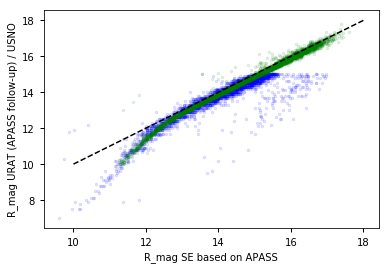

In [12]:
plt.plot(cat_SE_match_USNO["RMAG_AUTO"], cat_USNO_match["Rmag"], "b.", ms=5, alpha=0.1)
plt.plot(cat_SE_match_URAT["RMAG_AUTO"], cat_URAT_match["rmag"], "g.", ms=5, alpha=0.1)
plt.xlabel("R_mag SE based on APASS")
plt.ylabel("R_mag URAT (APASS follow-up) / USNO")
x = np.linspace(10,18)
plt.plot(x,x,"k--")

In [13]:
cat_1 = join(cat_SE_match_URAT, cat_URAT_match, keys='NUMBER')
cat_2 = join(cat_SE_match_USNO, cat_USNO_match, keys='NUMBER')
cat_1.keep_columns(["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","FLAGS","RMAG_AUTO",
                   "ID_URAT","X_IMAGE_URAT","Y_IMAGE_URAT","rmag","gmag"])
cat_2.keep_columns(["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","FLAGS","RMAG_AUTO",
                   "ID_USNO","X_IMAGE_USNO","Y_IMAGE_USNO","Rmag"])

In [14]:
df_SE_match_all =  pd.merge(cat_1.to_pandas(), cat_2.to_pandas(), how='outer')
df_SE_match_all

NUMBER    X_IMAGE    Y_IMAGE  ELLIPTICITY  FLAGS  RMAG_AUTO  ID_URAT  \
0         51  1848.6473     2.5820        0.200     24  16.151374    331.0   
1         59  4194.6675     2.1220        0.224     26  15.916669    731.0   
2         80  1455.9669     4.7333        0.153     24  16.118519    221.0   
3         99  1399.6002     8.9973        0.152     16  16.411996    218.0   
4        133  3618.3416    12.6720        0.131      0  16.561322    625.0   
5        155  1590.9924    10.3663        0.142      0  15.826348    209.0   
6        161  4483.4463     9.5515        0.083      0  15.242686    710.0   
7        197  4514.9175    11.9952        0.021      3  15.155876    709.0   
8        209  1235.5865    21.4453        0.167      0  16.197318    188.0   
9        226  4425.9097    25.9294        0.108      0  16.905697    692.0   
10       227  4234.3501    30.8251        0.103      0  17.392395    734.0   
11       240  2303.3477    20.1252        0.122      0  14.926580    159.0   
12       241  1974.6161    23.0306        0.142      0  15.640968    342.0   
13       242  3663.5857    25.1067        0.218      0  15.930692    656.0   
14       245  4798.5430    33.0305        0.017      0  15.372315    696.0   
15       248  3348.4639    26.5221        0.104      3  16.024464   1179.0   
16       277  1367.9689    16.7205        0.182      3  16.537043    225.0   
17       285  3004.1487    13.2419        0.115      0  14.196503   1072.0   
18       286  3435.7739    18.6085        0.111      0  13.943610   1176.0   
19       294  1014.5935    24.6162        0.154      0  14.987376    238.0   
20       295  1558.8683    24.6677        0.147      0  14.785473    229.0   
21       296  2255.8384    25.2066        0.166      0  14.715897    149.0   
22       298  3825.0571    29.4946        0.111      0  15.654050    655.0   
23       310  1601.9767    32.1900        0.153      0  15.669165    212.0   
24       333  1224.4414    31.6429        0.139      0  15.462331    189.0   
25       334  2745.5981    35.1490        0.124      0  15.529262   1103.0   
26       342  1816.6378    20.3551        0.076      0  14.045794    332.0   
27       343  4015.1921    41.7234        0.119      0  16.113383    646.0   
28       371  4622.0488    35.5231        0.030      2  15.149420    708.0   
29       376  1564.6871    46.7372        0.178      0  16.256688    228.0   
...      ...        ...        ...          ...    ...        ...      ...   
5130   35749  2908.4399  3560.5547        0.063      0  16.039164      NaN   
5131   36103  1897.5651  3517.8777        0.188      0  16.956162      NaN   
5132   36191   612.3060  3641.7729        0.173      0  16.426681      NaN   
5133   36218   533.0074  3503.3108        0.091      0  16.352810      NaN   
5134   36510  1796.9034  3438.3787        0.539      3  15.249616      NaN   
5135   36550  3813.1396  3440.6833        0.020      4  11.175560      NaN   
5136   36568   913.3731  3470.1343        0.035      3  16.407717      NaN   
5137   37146  3561.3994  3399.0366        0.138      3  14.259667      NaN   
5138   37169  3557.1223  3394.6348        0.075      3  14.365655      NaN   
5139   37926  4911.2778  3290.8452        0.032      6  11.015292      NaN   
5140   38097  5455.2437  3299.1682        0.097      3  14.141100      NaN   
5141   38109  5454.6475  3294.0220        0.181      3  14.769900      NaN   
5142   38217  4151.0386  3267.4456        0.086      6   9.965366      NaN   
5143   38438  3567.1016  3142.3464        0.086      6  10.964447      NaN   
5144   38472  1709.4155  3262.3508        0.243      1  16.098885      NaN   
5145   38506  1640.0197  3242.3518        0.087      3  15.076375      NaN   
5146   38536   708.7216  3264.6821        0.025      0  16.953108      NaN   
5147   38975   437.3978  3213.4980        0.107      0  16.314948      NaN   
5148   38999   793.2587  3200.9983        0.082      0  15.920824      NaN   
5149   39020  1789.5714  320

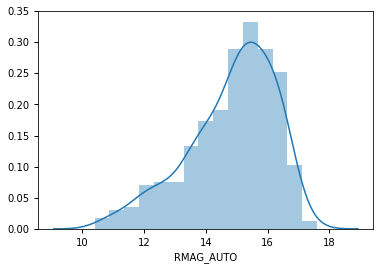

In [15]:
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)
sns.distplot(df_SE_match['RMAG_AUTO'])

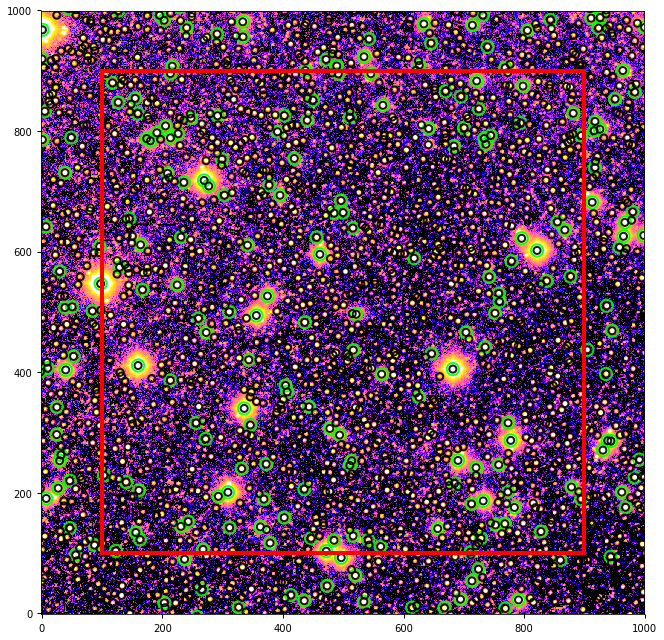

In [187]:
patch_xmin, patch_ymin = coord_Im2Array(patch_Xmin, patch_Ymin)
patch_xmax, patch_ymax = coord_Im2Array(patch_Xmax, patch_Ymax)

fig, ax = plt.subplots(figsize=(10,9))

plt.scatter(df_SE_match["X_IMAGE"] - patch_ymin-1, df_SE_match["Y_IMAGE"] - patch_xmin-1, s=150, lw=2., 
            edgecolors="lime", facecolors="None",alpha=0.9)
plt.scatter(SE_cat["X_IMAGE"] - patch_ymin-1, SE_cat["Y_IMAGE"] - patch_xmin-1, s=50, lw=2., 
            edgecolors="k", facecolors="None",alpha=0.9)

plt.imshow(patch, vmin=mu, vmax=mu+20*std, norm=norm1, origin="lower", cmap="gnuplot2")
rect = patches.Rectangle((100,100),800,800,linewidth=4,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.tight_layout()
# plt.savefig("Match_URAT_USNO.pdf")

med, std: 884.6563738933864 4.016418088032554
1.4419490906310513 882.0717298678242 2.1474899440679227


Text(0.5, 1.0, "'SKY' distribution")

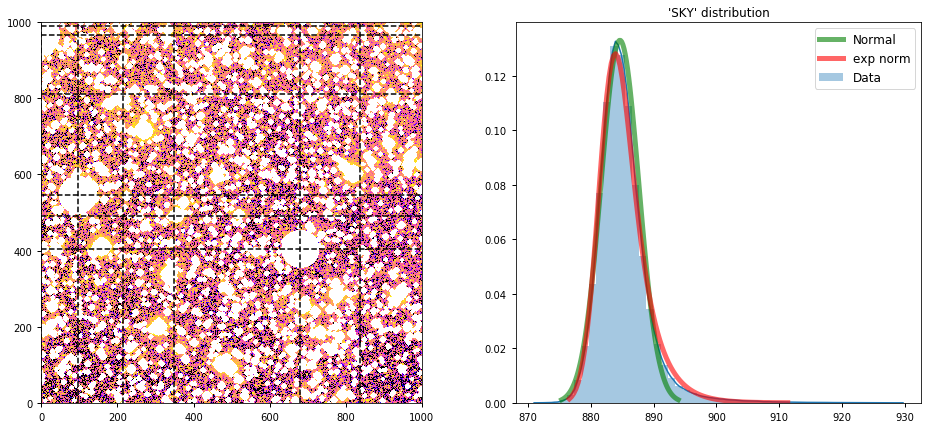

In [20]:
yy, xx  = np.indices(patch.shape)
df_SE_match_b = df_SE_match.sort_values("RMAG_AUTO").iloc[:10]
dist_maps = np.array([np.sqrt((xx-pos[0]+patch_Xmin)**2+(yy-pos[1]+patch_Ymin)**2)
                        for pos in zip(df_SE_match_b["X_IMAGE"], df_SE_match_b["Y_IMAGE"])])
mask_bright = np.logical_or.reduce(dist_maps<50)

seg_patch3 = seg_patch.copy()
for i in range(5):
    seg_patch3 = morphology.dilation(seg_patch3)

mask_source = seg_patch3 | mask_bright
patch3 = patch.copy()
patch3[mask_source!=0] = np.nan
med_sky, std_sky =  np.nanmedian(patch3), np.nanstd(patch3)
print("med, std:", med_sky, std_sky)

plt.figure(figsize=(16,7))
ax = plt.subplot(121)
ax.imshow(patch3, vmin=med_sky-3, vmax=med_sky+30, norm=norm1, origin="lower", cmap="gnuplot2")
ax.set_xlim(0,1000)
ax.set_ylim(0,1000)
[ax.axhline(y-patch_Ymin, color='k',ls='--') for y in df_SE_match_b["Y_IMAGE"]]
[ax.axvline(x-patch_Xmin, color='k',ls='--') for x in df_SE_match_b["X_IMAGE"]]

ax = plt.subplot(122)
z_sky = patch3[~np.isnan(patch3)]
sns.distplot(z_sky, label='Data', ax=ax)

d_mod = stats.norm(loc=med_sky, scale=3.)
x = np.linspace(d_mod.ppf(0.001), d_mod.ppf(0.999), 100)
ax.plot(x, d_mod.pdf(x), 'g-', lw=5, alpha=0.6, label='Normal')

K_fit, med_fit, std_fit = stats.exponnorm.fit(z_sky)
print(K_fit, med_fit, std_fit)
d_mod2 = stats.exponnorm(loc=med_fit, scale=std_fit, K=K_fit)
x = np.linspace(d_mod2.ppf(0.001), d_mod2.ppf(0.9999), 100)
ax.plot(x, d_mod2.pdf(x), 'r-', lw=5, alpha=0.6, label='exp norm')

ax.legend(fontsize=12)
ax.set_title("'SKY' distribution")

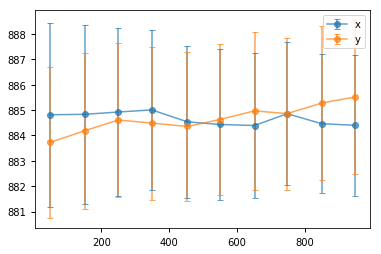

In [23]:
x_sky = xx[~np.isnan(patch3)].ravel()
y_sky = yy[~np.isnan(patch3)].ravel()
z_sky = patch3[~np.isnan(patch3)].ravel()
N = 10
dL = patch.shape[0]//N
x_ms, y_ms, z_ms, zerr_ms = np.zeros(N), np.zeros(N), np.zeros((N,2)), np.zeros((N,2))
for i in range(N):
    yslice = abs(y_sky-dL//2-i*(dL))<=dL//2
    xslice = abs(x_sky-dL//2-i*(dL))<=dL//2
    x_ms[i] = np.median(x_sky[xslice])
    y_ms[i] = np.median(y_sky[yslice])
    z_ms[i] = np.median(z_sky[xslice]), np.median(z_sky[yslice])
    zerr_ms[i] = mad_std(z_sky[xslice]), mad_std(z_sky[yslice])
plt.errorbar(y_ms, z_ms[:,0], zerr_ms[:,0], fmt='-o', capsize=3, alpha=0.7,label="x")
plt.errorbar(y_ms, z_ms[:,1], zerr_ms[:,1], fmt='-o', capsize=3, alpha=0.7,label="y")
plt.legend()

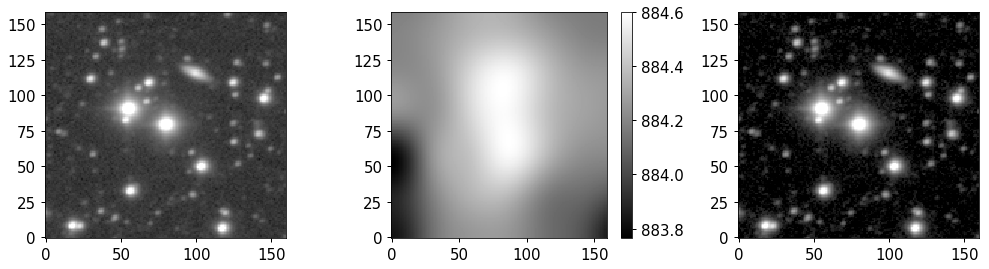

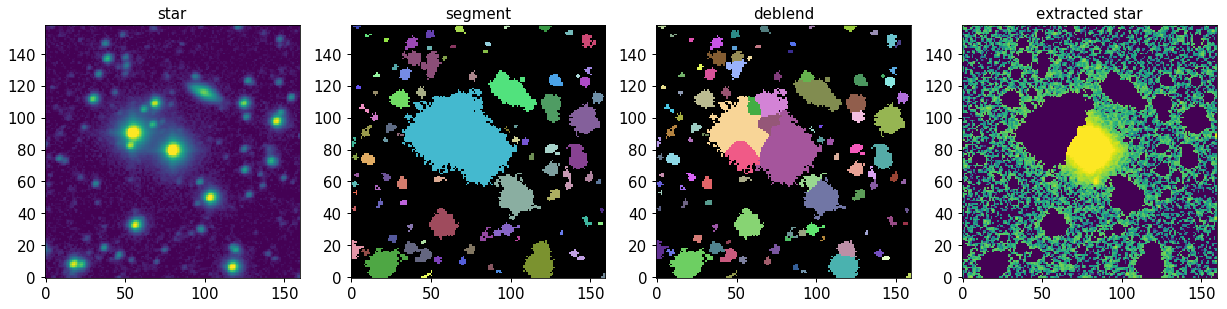

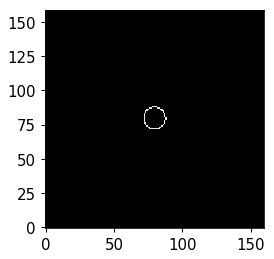

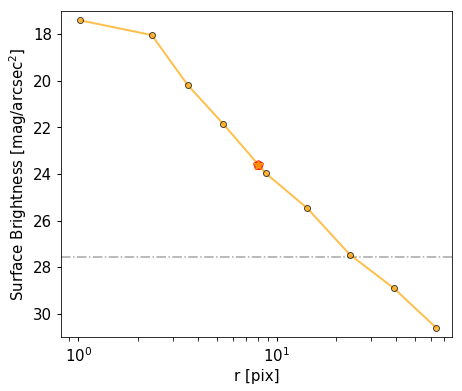

In [280]:
num = 22036
ind = num-1
img, ma, back, cen = extract_star(ind, SE_cat_full, display_bg=True, display=True)
plt.show()
z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=8, wid=0.5, display=True)
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                             ZP=ZP, sky_mean=mu, sky_std=std,
                                             xunit="pix", yunit="SB", color="orange",
                                             core_undersample=False, scatter=False, plot_line=False)
plt.xscale("log")
plt.plot(8, Intensity2SB(z_mean, mu, ZP, pix_scale),"p", ms=10, color="r",zorder=4,alpha=0.8)
plt.plot(8, Intensity2SB(z_med, mu, ZP, pix_scale),"*", ms=10, color="orange",zorder=4,alpha=0.8)

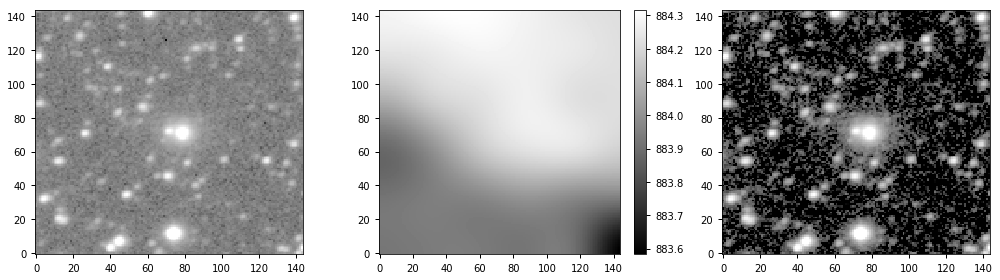

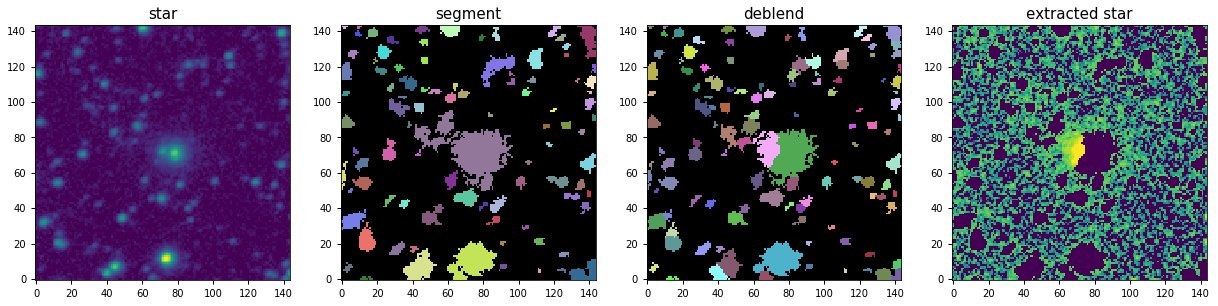

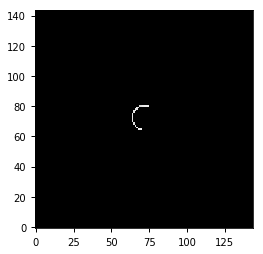

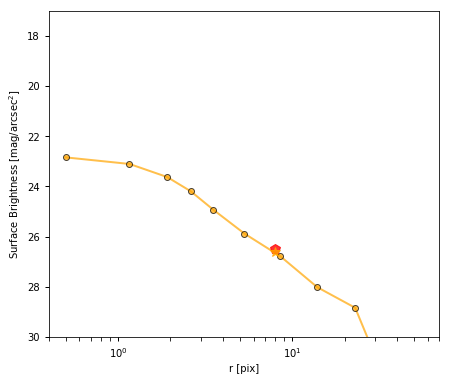

In [17]:
num = 18154
ind = num-1
img, ma, back, cen = extract_star(ind, SE_cat_full, display_bg=True, display=True)
plt.show()
z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=8, wid=0.5, display=True)
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                             ZP=ZP, sky_mean=mu, sky_std=std,
                                             xunit="pix", yunit="SB", color="orange",
                                             core_undersample=False, scatter=False, plot_line=False)
plt.xscale("log")
plt.plot(8, Intensity2SB(z_mean, mu, ZP, pix_scale),"p", ms=10, color="r",zorder=4,alpha=0.8)
plt.plot(8, Intensity2SB(z_med, mu, ZP, pix_scale),"*", ms=10, color="orange",zorder=4,alpha=0.8)

In [188]:
# target = df_SE_match["RMAG_AUTO"] < 15
target = ((df_SE_match["RMAG_AUTO"] >11.9) & (df_SE_match["RMAG_AUTO"] < 12.1)) \
         | ((df_SE_match["RMAG_AUTO"] >14.9) & (df_SE_match["RMAG_AUTO"] < 15.1))
num_target = np.sum(target)
df_SE_target = df_SE_match[target]
df_SE_target

NUMBER    X_IMAGE    Y_IMAGE  ELLIPTICITY  FLAGS  RMAG_AUTO  ID_URAT  \
18    11489  1250.8956  2958.4207        0.022      3  14.988484   3211.0   
19    11496  1020.6262  2919.1272        0.120      7  12.023839   3078.0   
29    11682  1227.3322  2935.9099        0.043      2  15.054747   3210.0   
41    12217  1248.4412  2878.2065        0.060      2  15.082075   3209.0   
47    12328   888.5053  2862.7800        0.153      3  14.926689   3075.0   
52    12531  1089.9551  2842.1865        0.160      3  14.951988   3193.0   
65    12998  1028.3604  2805.2231        0.076      2  15.033041   3062.0   
99    13990  1289.3584  2707.6631        0.060      2  14.996044   3190.0   
117   14531   955.0561  2654.1111        0.076      0  15.036508   3048.0   
121   14610   927.0231  2647.5186        0.081      0  15.052826   3041.0   
150   15174  1694.6715  2592.3826        0.058      0  15.090444   3142.0   
164   15605  1951.2766  2549.6548        0.052      0  14.919568   3152.0   
166   15656   695.9269  2545.0061        0.090      0  15.004354   3011.0   
173   15940  1035.8015  2514.8115        0.096      0  14.940896   3035.0   
174   15991   611.3099  2510.5393        0.100      0  14.913869   3008.0   
190   16623  1655.0708  2449.2263        0.070      0  14.999205   3107.0   
193   16719  1316.0693  2439.0334        0.064      0  15.056355   2985.0   
218   17617  1936.4606  2348.8469        0.061      0  15.033575   1742.0   
228   18048   838.7174  2307.1868        0.088      3  15.074838   2995.0   
236   18458  1745.7400  2268.7339        0.109      0  15.042638   3099.0   
245   18887  1143.4755  2220.6858        0.209      0  15.012878   2947.0   
248   18964   701.9282  2213.0156        0.091      0  15.045191   2810.0   
268   19931  1577.6570  2087.0212        0.077      6  11.932344   2966.0   
269   19954   601.2157  2107.1394        0.076      6  12.072957   2795.0   
287   20622  1314.0791  2053.1929        0.130      3  14.905749   2972.0   
290   20678  1172.3502  2047.7201        0.089      0  14.914333   2942.0   
311   21189  1573.0618  2001.5615        0.110      0  15.029969   2962.0   
335   21804  1111.6968  1942.3395        0.092      0  15.069746   2931.0   
345   22036  1296.7020  1892.5483        0.030      6  11.989254   2921.0   
360   22579  1524.3466  1873.4485        0.200      0  14.985838   2950.0   
376   23220  1126.7498  1810.2839        0.089      0  15.066994   2927.0   
388   23604  1588.8206  1750.2113        0.054      2  15.047735   1531.0   
422   24843  1691.7736  1653.7963        0.070      0  14.928725   1519.0   
425   24993  1449.2028  1625.3021        0.023      4  11.945708   1489.0   
430   25237  1167.3528  1616.7400        0.092      0  14.936744   2712.0   
433   25314  1081.3612  1609.2633        0.093      0  14.955714   2711.0   
465   24466  1095.2345  1689.3997        0.168      3  15.027071      NaN   
466   24934  1945.0156  1639.9276        0.044      2  15.024370      NaN   

          gmag    rmag  X_IMAGE_URAT  Y_IMAGE_URAT  ID_USNO  Rmag  \
18   16.124001  14.839     1250.8765     2958.5380      NaN   NaN   
19   12.043000  11.548     1020.4079     2919.0241   3115.0  12.0   
29   15.369000  14.924     1227.1902     2935.8736   2962.0  14.8   
41   15.319000  14.904     1248.3569     2878.1990   2942.0  14.8   
47   15.566000  14.817      888.3752     2862.7408   3193.0  14.7   
52   15.165000  14.905     1089.9080     2842.1721   3060.0  14.8   
65   15.356000  14.903     1028.3193     2805.2181   3108.0  14.7   
99   15.812000  14.828     1289.0827     2707.7477      NaN   NaN   
117  15.263000  14.851      954.9347     2654.1051   3155.0  14.7   
121  15.492000  14.862      926.9119     2647.5274   3166.0  14.6   
150  15.628000  14.988     1694.6320     2592.3443   2597.0  14.6   
164  15.103000  14.789     1951.2194     2549.6449   2410.0  14.6   
166  15.165000  14.824      695.8056     2545.0287   3300.0  14.8   
173  15.517000  14.756     1035.640

In [189]:
img_list, ma_list, bk_list, cen_list = [{} for i in range(4)]
res_Rnorm = np.empty((len(df_SE_target),4))
for i, num in enumerate(df_SE_target['NUMBER']):
    
    process_counter(i, len(df_SE_target))
    
    ind = num - 1
    img, ma, bk, cen = extract_star(ind, SE_cat_full, display_bg=False, display=False)
    
    img_list[num] = img
    ma_list[num] = ma
    bk_list[num] = bk
    cen_list[num] = cen    
    
    z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=8, wid=0.5)
    sky_mean = np.median(bk)
    res_Rnorm[i] = np.array([z_mean, z_med, z_std, sky_mean])
    
z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm.T

completed: 7/38
completed: 14/38
completed: 21/38
completed: 28/38
completed: 35/38


In [31]:
table_res_Rnorm = Table(np.hstack([df_SE_target['NUMBER'].values[:, None],
                                  df_SE_target['X_IMAGE'].values[:, None],
                                  df_SE_target['Y_IMAGE'].values[:, None],res_Rnorm]), 
                     names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)
# table_res_Rnorm.write('Rnorm_8pix_15mag_p2.txt', overwrite=True, format='ascii')

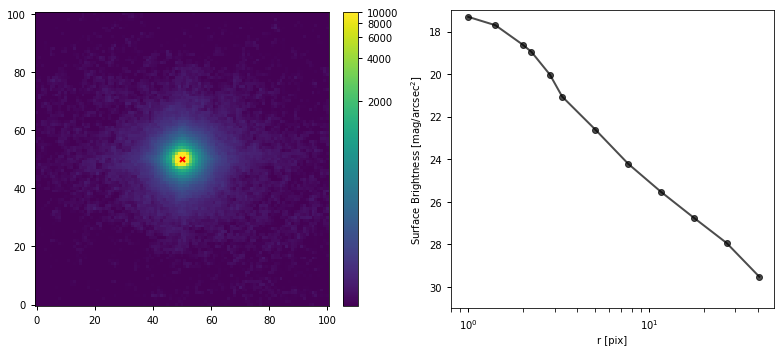

In [48]:
hdu = fits.open("./med_psf_JX.fits")[0]
PSF_JX = hdu.data * 10 + mu

fig = plt.figure(figsize=(11,5))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             core_undersample=True, plot_line=False)
ax2.set_ylim(31,17)
plt.tight_layout()

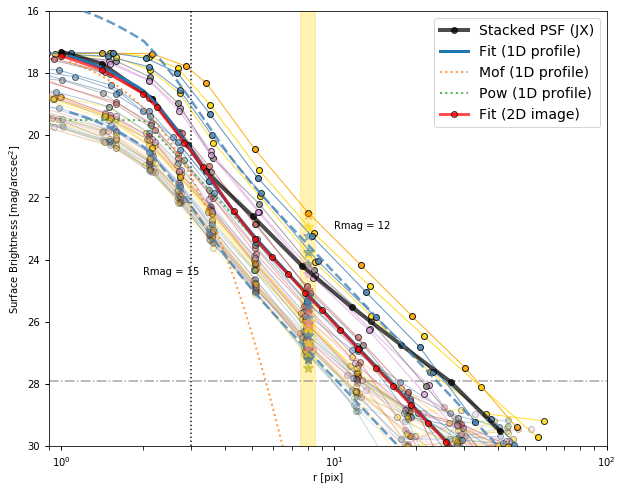

In [169]:
# import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "plum", "orange", "gray", "brown" ]
random.seed(42)
rand_colours = [random.choice(colour) for i in range(50)]

plt.figure(figsize=(10,8))

for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
    img, ma, cen = img_list[num], ma_list[num], cen_list[num]
    alpha = min(0.2*(16-rmag), 0.9)
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                 ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                 xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha,
                                                 core_undersample=False, plot_line=False)
    
plt.fill_betweenx([30,16.], x1=7.5, x2=8.5, color="gold", alpha=0.3)

for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
    plt.plot(8, Intensity2SB(z_m, sky_m, ZP, pix_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                             ZP=ZP, sky_mean=mu, sky_std=3, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                             core_undersample=False, plot_line=True)

plt.plot(r, I_tot, ls="-", lw=3, label="Fit (1D profile)", zorder=3)
plt.plot(r, I_1, ls=":", lw=2., label="Mof (1D profile)", alpha=0.8, zorder=3)
plt.plot(r, I_2, ls=":",lw=2.,  label="Pow (1D profile)", alpha=0.8, zorder=3)
plt.plot(r, I_tot-1.6, ls="--", color="steelblue", lw=2.5, alpha=0.8, zorder=3)
plt.plot(r, I_tot+1.8, ls="--", color="steelblue", lw=2.5, alpha=0.8, zorder=3)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2+mu, pix_scale=pix_scale, 
                                              sky_mean=mu, seeing=2.5, color="r", lw=3,
                                              core_undersample=True, xunit="pix", yunit="SB", label="Fit (2D image)")
plt.annotate("Rmag = 12", (10, 23))
plt.annotate("Rmag = 15", (2, 24.5))
plt.legend(fontsize=14)
plt.ylim(30,16.)
plt.xlim(0.9,100)
plt.xscale("log")

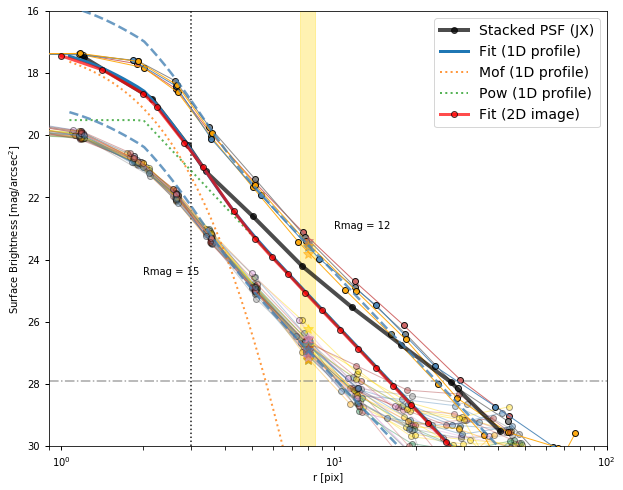

In [191]:
# import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "plum", "orange", "gray", "brown" ]
random.seed(42)
rand_colours = [random.choice(colour) for i in range(50)]

plt.figure(figsize=(10,8))

for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
    img, ma, cen = img_list[num], ma_list[num], cen_list[num]
    alpha = min(0.4*(16-rmag), 0.9)
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                 ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                 xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha,
                                                 core_undersample=False, plot_line=False)
    
plt.fill_betweenx([30,16.], x1=7.5, x2=8.5, color="gold", alpha=0.3)

for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
    plt.plot(8, Intensity2SB(z_m, sky_m, ZP, pix_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                             ZP=ZP, sky_mean=mu, sky_std=3, pix_scale=pix_scale, 
                                             xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                             core_undersample=False, plot_line=True)

plt.plot(r, I_tot, ls="-", lw=3, label="Fit (1D profile)", zorder=3)
plt.plot(r, I_1, ls=":", lw=2., label="Mof (1D profile)", alpha=0.8, zorder=3)
plt.plot(r, I_2, ls=":",lw=2.,  label="Pow (1D profile)", alpha=0.8, zorder=3)
plt.plot(r, I_tot-1.6, ls="--", color="steelblue", lw=2.5, alpha=0.8, zorder=3)
plt.plot(r, I_tot+1.8, ls="--", color="steelblue", lw=2.5, alpha=0.8, zorder=3)

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2+mu, pix_scale=pix_scale, 
                                              sky_mean=mu, seeing=2.5, color="r", lw=3,
                                              core_undersample=True, xunit="pix", yunit="SB", label="Fit (2D image)")
plt.annotate("Rmag = 12", (10, 23))
plt.annotate("Rmag = 15", (2, 24.5))
plt.legend(fontsize=14)
plt.ylim(30,16.)
plt.xlim(0.9,100)
plt.xscale("log")

### Open Fit Result

In [45]:
res = open_nested_fitting_result(filename='./real/fit_real.res')

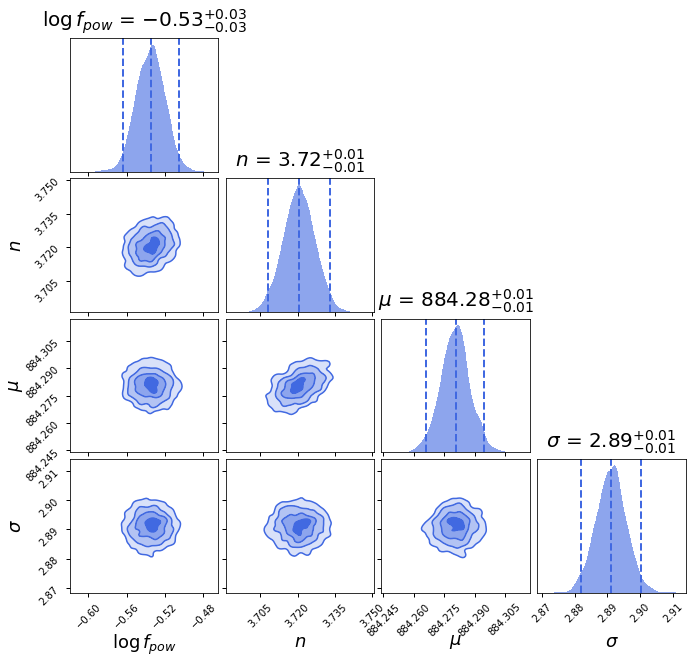

In [46]:
from dynesty import plotting as dyplot

labels = [r'$\log\,f_{pow}$', r'$n$', r'$\mu$', r'$\sigma$']
fig, axes = dyplot.cornerplot(res, show_titles=True, 
                              color="royalblue", truth_color="indianred",
                              title_kwargs={'fontsize':20, 'y': 1.04}, labels=labels,
                              label_kwargs={'fontsize':18},
                              fig=plt.subplots(4, 4, figsize=(10, 9)))
    
pmed, pmean, pcov = get_params_fit(res)

(31, 17)

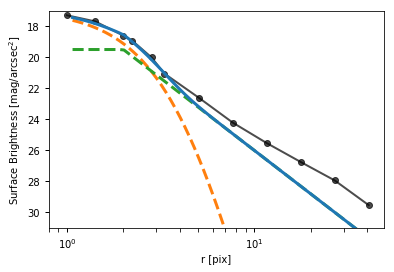

In [49]:
# PSF Parameters
n_fit = pmed[1]                     # true power index
f_fit = 10**pmed[0]                 # fraction of power law component
flux = 6e5
theta_t = 5.
theta_t_pix = theta_t / pix_scale 

beta_psf = 10
fwhm = 2.28 * pix_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pix_scale  

r = np.logspace(0.03,2.5,100)
c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
c_pow2Dto1D = C_pow2Dto1D(n_fit, theta_t_pix)

comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D
comp2 = trunc_power1d_normed(r, n_fit, theta_t_pix) / c_pow2Dto1D

I_tot = Intensity2SB((1-f_fit) * comp1 + comp2 * f_fit, 0, ZP, pix_scale)-14.5
I_1 = Intensity2SB((1-f_fit) * comp1, 0, ZP, pix_scale)-14.5
I_2 = Intensity2SB(comp2 * f_fit, 0, ZP, pix_scale)-14.5

plt.plot(r, I_tot, ls="-", lw=3, label="Mof + Pow 1D",zorder=5)
plt.plot(r, I_1, ls="--", lw=3, label="Moffat1D",zorder=1)
plt.plot(r, I_2, ls="--",lw=3,  label="Power1D")

r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                              ZP=ZP, sky_mean=mu, sky_std=1e-2, pix_scale=pix_scale,
                                              xunit="pix", yunit="SB", color="k",
                                              core_undersample=True, plot_line=False)
plt.xscale("log")
plt.ylim(31,17)

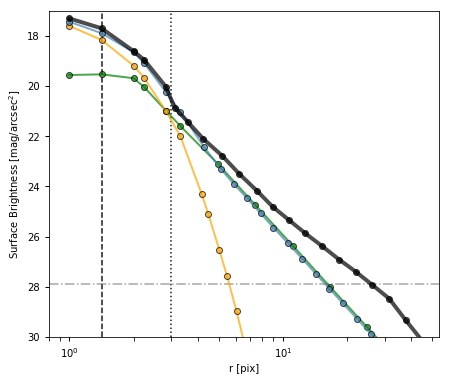

In [50]:
import galsim
def Generate_PSF_pow_Galsim(contrast, n=n_fit, psf_scale=1.5, 
                            psf_size=None, min_psf_size=None, max_psf_size=None,
                            x_interpolant="lanczos3", k_interpolant="lanczos3"):
    if psf_size is None:
        a = (theta_t/psf_scale)**n
        opt_psf_size = 2 * int((contrast * a) ** (1./n))
        opt_psf_size = round_good_fft(opt_psf_size)
        psf_size = max(min_psf_size, min(opt_psf_size, max_psf_size))

    cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
    yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
    
    theta0_psf = theta_t / psf_scale
    psf_model = trunc_power2d(xx_psf, yy_psf, n, cen=cen_psf, theta0=theta0_psf, I_theta0=1) 
    image_psf = galsim.ImageF(psf_model)
    
    psf_pow = galsim.InterpolatedImage(image_psf, flux=1, scale=psf_scale,
                                       x_interpolant=x_interpolant, k_interpolant=k_interpolant)
    return psf_pow, psf_size

# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_pow, psf_size = Generate_PSF_pow_Galsim(contrast=1e4, n=n_fit, 
                                            psf_size=1024,
                                            psf_scale=1.5)
psf_pow_2 = psf_pow.withFlux(flux)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-7)
psf_mof = galsim.Moffat(beta=beta_psf, flux=flux, fwhm=fwhm, gsparams=gsparams) # in arcsec
    
img_pow_2 = psf_pow_2.drawImage(nx=201, ny=201, scale=pix_scale, method="no_pixel").array
img_mof = psf_mof.drawImage(nx=17, ny=17, scale=pix_scale, method="no_pixel").array

star_psf = (1-f_fit)*psf_mof + f_fit*psf_pow_2
star_psf_2 = star_psf.withFlux(flux)

img_gs_2 = star_psf_2.drawImage(nx=601, ny=601, scale=pix_scale, method="no_pixel").array

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(f_fit*img_pow_2+mu, pix_scale=pix_scale, sky_mean=mu, seeing=2.5, 
                                             core_undersample=True,xunit="pix", yunit="SB", color="g")
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d((1-f_fit)*img_mof+mu, pix_scale=pix_scale, sky_mean=mu, seeing=2.5, 
                                             core_undersample=True,xunit="pix", yunit="SB", color="orange")
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2+mu, pix_scale=pix_scale, sky_mean=mu, seeing=2.5,  
                                             core_undersample=True,xunit="pix", yunit="SB", label="Galsim PSF")
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50), mask=None, 
                                             ZP=ZP, sky_mean=mu, sky_std=3, pix_scale=pix_scale, dr=0.3,
                                             xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF",
                                             core_undersample=True, plot_line=True)
plt.ylim(30,17)
plt.xscale("log")

#### Screen out possible galaxy

In [ ]:
import dynesty
from dynesty import plotting as dyplot
import time
import multiprocess as mp

tab = SE_cat_full[SE_cat_full["RMAG_AUTO"]<18]
X = tab["RMAG_AUTO"]
Y = tab["MU_MAX"]

Run_2lin_Nested_Fitting(X, Y, {"loc":[12,-10,0.5,0],"scale":[1,1,1,0.3]}, display=True)

iter: 40 | batch: 0 | bound: 0 | nc: 1 | ncall: 45 | eff(%): 20.513 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.282 | dlogz:    inf >  0.159                                           

Opening pool: # of CPU used: 3


iter: 3729 | batch: 3 | bound: 48 | nc: 1 | ncall: 13534 | eff(%): 27.553 | loglstar: -2380.639 < -2376.648 < -2377.571 | logz: -2394.944 +/-  0.472 | stop:  4.280                                   


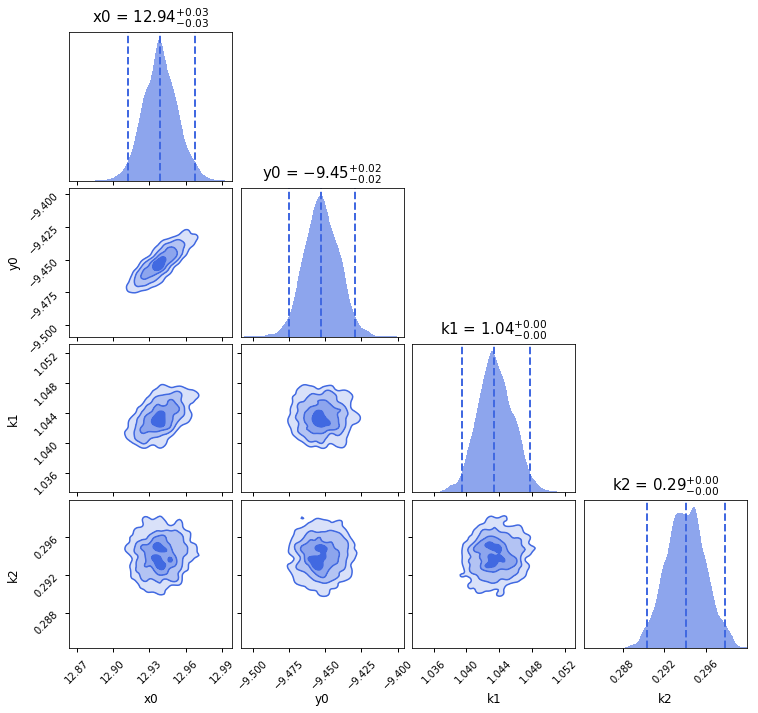

In [24]:


def prior_transform(u):
    v = u.copy()
    v[0] = u[0] + 12  #x0: 12-13
    v[1] = u[1] - 10  #y0: -10 - -9
    v[2] = u[2] + 0.5  #k2
    v[3] = u[3] * 0.3  #sigma
    
    return v

def loglike(v):
    x0, y0, k2, sigma = v
    
    ypred = np.piecewise(X, [X < x0], [lambda x: y0, lambda x: k2*x + y0-k2*x0])
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike=loglike, 
                       prior_transform=prior_transform, 
                       ndim=4,
                       nlive_init=150, nlive_batch=50, maxbatch=3,
                       print_progress=True):
        
    with mp.Pool(processes=3) as pool:
        print("Opening pool: # of CPU used: %d"%(3))
        pool.size = 3

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                  pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=print_progress, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

pdsampler = Run_Nested_Fitting(loglike=loglike, prior_transform=prior_transform, ndim=4)
pdres = pdsampler.results
labels = ["x0", "y0", "k1", "k2", "sigma"]
fig, axes = dyplot.cornerplot(pdres,show_titles=True, 
                              color="royalblue", 
                              title_kwargs={'fontsize':15, 'y': 1.02}, labels=labels,
                              label_kwargs={'fontsize':12},
                              fig=plt.subplots(4, 4, figsize=(11, 10)))

<Table length=51>
NUMBER FLUX_AUTO FLUXERR_AUTO  X_IMAGE  ... FLAGS CLASS_STAR     RMAG_AUTO     
           ct         ct         pix    ...                          ct        
int64   float64    float64     float64  ... int64  float64        float64      
------ --------- ------------ --------- ... ----- ---------- ------------------
 11039  53034.95     223.6754 1816.4716 ...     0      0.034 15.284748582008284
 11724  4393.015     90.97053 1631.6957 ...     0      0.018  17.98924727594523
 11744  38043.11     206.0028 1181.0264 ...     3      0.029  15.64546395883909
 12103   51161.5     223.4651 1768.5222 ...     2      0.274 15.323795818775853
 12240  41315.28     206.6461  883.8828 ...     3      0.037 15.555877240416402
 12267  4402.252     92.30737 1151.0586 ...     0       0.01 17.986966742787892
 12529  8313.897     144.6937 1103.9752 ...     3        0.0  17.29664239193698
 12532  6282.377     113.8563 1052.8845 ...     3      0.001 17.600844005173506
 12619  5114.653      103.888 1930.5148 ...     3        0.0  17.82411355475613
   ...       ...          ...       ... ...   ...        ...                ...
 22488  4400.385     99.23821  795.6777 ...     0        0.0 17.987427302396263
 23102  25048.81     160.1565 1003.3976 ...     3      0.029  16.09918624497811
 23453  5473.917     84.37679 1008.2213 ...     2      0.026  17.75040847138252
 23553  18378.75     141.9755 1839.0719 ...     3      0.033  16.43536406577269
 24241  5605.688     85.86596  607.3029 ...     0      0.025 17.724581685769138
 24528  5155.117     91.30006  631.1844 ...     0      0.031  17.81555767528895
 24579   5384.99     89.76058  608.0424 ...     3      0.001  17.76819173851365
 24662  8554.944     99.21692 1575.3623 ...     0      0.027   17.2656110638025
 25285  11648.68     122.4762  781.7999 ...     0      0.029 16.930462203976102
 25298  4988.438     111.1502 1428.7417 ...     0        0.0  17.85124254423709

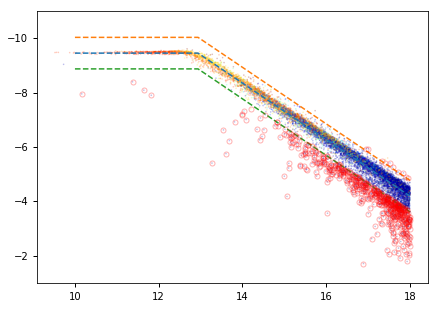

In [201]:
plt.figure(figsize=(7,5))
plt.scatter(tab["RMAG_AUTO"], tab["MU_MAX"], c=tab["CLASS_STAR"], marker=".", cmap="jet", s=2, alpha=0.2)

x0, y0, k1, k2, sigma = 12.94, -9.45, 0, 1.04, 0.29
xnew = np.linspace(10,18)
f_fit = lambda x: np.piecewise(x, [x < x0], [lambda x: k1*x + y0-k1*x0, lambda x: k2*x + y0-k2*x0])
ynew = f_fit(xnew)
plt.plot(xnew, ynew, xnew, ynew-2*sigma, xnew, ynew+2*sigma, ls="--")
outlier = (abs(tab["MU_MAX"] - f_fit(tab["RMAG_AUTO"])) > 2 * sigma) & (tab["CLASS_STAR"]<0.7)
plt.plot(tab["RMAG_AUTO"][outlier], tab["MU_MAX"][outlier],'ro', ms=5,mfc="None",alpha=0.3)
plt.ylim(-1, -11)

tab_outlier = crop_catalog(tab[outlier], bounds, keys=("X_IMAGE", "Y_IMAGE"))
tab_outlier

### Remove galaxies

In [192]:
# Prepare for quearyinig Vizier with filters up to infinitely many rows. By default, this is 50.
viz_filt = Vizier(columns=['RAJ2000', 'DEJ2000',  'Kr.eff'])
viz_filt.ROW_LIMIT = -1

RA, DEC = re.split(",", header['RADEC'])
coords = SkyCoord(RA+" "+DEC , unit=(u.hourangle, u.deg))

# Query!
result_2MASS = viz_filt.query_region(coords, 
                                    radius=2*u.deg, 
                                    catalog=["2MASS Extended"])
Cat_2MASSx = result_2MASS['VII/233/xsc']

coords_2MASSx = np.vstack([np.array(Cat_2MASSx["RAJ2000"]), 
                         np.array(Cat_2MASSx["DEJ2000"])]).T
pos_2MASSx = w.wcs_world2pix(coords_2MASSx, 1)
Cat_2MASSx.add_column(Column(np.around(pos_2MASSx[:,0],4)*u.pix), name="X_IM_2MASS")
Cat_2MASSx.add_column(Column(np.around(pos_2MASSx[:,1],4)*u.pix), name="Y_IM_2MASS")
c_2MASSx = SkyCoord(ra=Cat_2MASSx["RAJ2000"], dec=Cat_2MASSx["DEJ2000"])
idx, d2d, d3d = c_SE.match_to_catalog_sky(c_2MASSx)
sep = d2d < 2.5 * u.arcsec
cat_SE_match_2MASSx = SE_cat_full[sep]
cat_2MASSx_match = Cat_2MASSx[idx[sep]]
cat_2MASSx_match.add_column(cat_SE_match_2MASSx["NUMBER"], index=0, name="NUMBER")

cat_2MASSx_match

<Table masked=True length=461>
NUMBER  RAJ2000    DEJ2000    Kr.eff X_IM_2MASS Y_IM_2MASS
          deg        deg      arcsec    pix        pix    
int64   float64    float64   float32  float64    float64  
------ ---------- ---------- ------- ---------- ----------
    66 227.618149  54.847626    2.22  4000.8154     2.5045
   372 230.206497  54.869518    6.17  1854.7115    32.1263
   413 227.284286  54.873837    3.23  4276.7767    46.2908
   477 230.707916  54.878159    2.84  1439.4032    53.3726
   687 227.694153  54.908161    2.27  3936.1584    88.5361
   737 230.984955  54.895077    2.78  1210.5319    83.8811
  1110 226.624023  54.926155    4.04  4821.4215    137.447
  1174 231.362473  54.931377    2.31   899.6322   145.9917
  1247 227.378983  54.955521    2.64  4195.5632   162.1289
   ...        ...        ...     ...        ...        ...
 40112 229.766769  57.004135    4.43   2254.559  3101.0981
 40218 226.023666  56.955639    3.12  5192.9749  3077.7028
 40393 229.602982  56.975815    2.65  2382.6356  3058.9779
 40397 228.876694  56.976814    2.11  2952.6524  3058.2074
 40487 226.684204  56.952850    3.18   4674.464  3053.7903
 40553 226.045105  56.931484    3.53  5177.6227   3042.209
 40562 230.258179  56.958698    3.40  1867.9583  3041.5203
 40565 226.033401  56.929253    2.55  5186.9556  3039.3928
 40580 229.413467  56.968479    3.21  2531.3066  3047.2522
 40586 230.244934  56.955921    3.33  1878.2842   3037.327

In [193]:
# Prepare for quearyinig Vizier with filters up to infinitely many rows. By default, this is 50.
viz_filt = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'class', 'rmag', 'rPrad'] ,
                  column_filters={'class':'=3'})
viz_filt.ROW_LIMIT = -1

RA, DEC = re.split(",", header['RADEC'])
coords = SkyCoord(RA+" "+DEC , unit=(u.hourangle, u.deg))

# Query!
result_sdss = viz_filt.query_region(coords, 
                                   radius=2*u.deg, 
                                   catalog=["sdss12"])
print(result_sdss)
Cat_sdss = result_sdss["V/147/sdss12"]

TableList with 1 tables:
	'0:V/147/sdss12' with 5 column(s) and 380250 row(s) 


In [194]:
Cat_sdss = Cat_sdss[Cat_sdss['rmag']<15]
coords_sdss = np.vstack([np.array(Cat_sdss["RA_ICRS"]), 
                         np.array(Cat_sdss["DE_ICRS"])]).T
pos_sdss = w.wcs_world2pix(coords_sdss, 1)
Cat_sdss.add_column(Column(np.around(pos_sdss[:,0],4)*u.pix), name="X_IM_SDSS")
Cat_sdss.add_column(Column(np.around(pos_sdss[:,1],4)*u.pix), name="Y_IM_SDSS")

c_sdss = SkyCoord(ra=Cat_sdss["RA_ICRS"], dec=Cat_sdss["DE_ICRS"])
idx, d2d, d3d = c_SE.match_to_catalog_sky(c_sdss)
sep = d2d < 2.5 * u.arcsec
cat_SE_match_sdss = SE_cat_full[sep]
cat_sdss_match = Cat_sdss[idx[sep]]
cat_sdss_match.add_column(cat_SE_match_sdss["NUMBER"], index=0, name="NUMBER")

cat_sdss_match

<Table masked=True length=168>
NUMBER  RA_ICRS    DE_ICRS   class   rmag   rPrad  X_IM_SDSS Y_IM_SDSS
          deg        deg             mag    arcsec    pix       pix   
int64   float64    float64   uint8 float32 float64  float64   float64 
------ ---------- ---------- ----- ------- ------- --------- ---------
   561 230.816260  54.848229     3  13.947   3.248 1348.4643   12.5449
  1160 229.678593  54.902123     3  11.380   3.672 2292.7703   73.0604
  1669 226.822598  54.896728     3   9.369   5.303  4658.389   89.7677
  2448 230.356102  54.991053     3  10.438   4.363 1734.2181  209.5359
  3423 229.992124  55.069623     3  10.218   4.209 2036.6643  317.5708
  3628 228.496862  55.095757     3  10.632   4.566  3269.566  350.4645
  4047 230.132042  55.163927     3  13.521   2.488 1923.5562  455.2147
  4075 230.665828  55.074704     3   9.130   5.408 1481.2376  335.6579
  4102 227.595423  55.119137     3  10.197   4.331 4011.8236  394.0238
   ...        ...        ...   ...     ...     ...       ...       ...
 38438 228.092627  57.032243     3   9.333   4.714 3566.9774 3142.4483
 38929 225.798839  57.041607     3  14.939   1.130 5363.7851 3209.3553
 38981 227.444860  57.000199     3  11.566  37.807  4075.621 3105.2724
 39121 228.263933  57.051754     3  10.100   3.904 3432.4428 3168.9813
 39132 230.500879  57.051225     3  12.365   3.397 1680.3499 3178.6756
 39185 230.264562  57.034602     3  10.849   4.165 1864.9943 3150.9203
 39854 229.314910  57.004748     3  14.664  19.590 2608.9309 3099.0454
 39970 229.468891  56.988860     3   9.901   4.280 2488.0099  3076.901
 40142 228.446161  56.974729     3  14.277   3.904 3290.5654 3056.7552
 40375 228.761024  56.969934     3  10.078   4.065 3043.4632 3048.5064

In [203]:
df_SE_gal = crop_catalog(cat_SE_match_2MASSx, bounds).to_pandas()

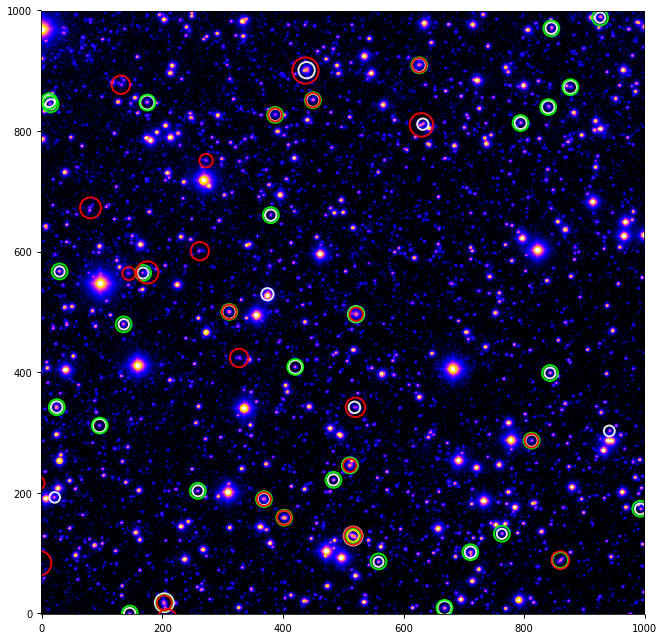

In [204]:
fig, ax = plt.subplots(figsize=(10,9))


plt.scatter(Cat_sdss["X_IM_SDSS"] - patch_ymin-1, Cat_sdss["Y_IM_SDSS"] - patch_xmin-1, 
            s=Cat_sdss["rPrad"]*10, lw=1.5, 
            edgecolors="gold", facecolors="None",alpha=0.9)
plt.scatter(Cat_2MASSx["X_IM_2MASS"] - patch_ymin-1, Cat_2MASSx["Y_IM_2MASS"] - patch_xmin-1, 
            s=Cat_2MASSx["Kr.eff"]*50, lw=2., 
            edgecolors="w", facecolors="None",alpha=0.9)
plt.scatter(df_SE_gal["X_IMAGE"] - patch_ymin-1, df_SE_gal["Y_IMAGE"] - patch_xmin-1, s=250, lw=2., 
            edgecolors="lime", facecolors="None",alpha=0.9)
plt.scatter(tab_outlier["X_IMAGE"] - patch_ymin-1, tab_outlier["Y_IMAGE"] - patch_xmin-1, 
            s=tab_outlier["FWHM_IMAGE"]*50, lw=2., 
            edgecolors="r", facecolors="None",alpha=0.9)
# [aper.plot(color="r") for aper in apers]

plt.imshow(patch, vmin=mu, vmax=10000, norm=norm1, origin="lower", cmap="gnuplot2")
rect = patches.Rectangle((100,100),800,800,linewidth=2,edgecolor='w',facecolor='none')
# ax.add_patch(rect)
plt.tight_layout()

In [128]:
from photutils import EllipticalAperture
pos = np.vstack([tab_outlier["X_IMAGE"] - patch_ymin-1, tab_outlier["Y_IMAGE"] - patch_xmin-1]).T
A = np.array(tab_outlier["FWHM_IMAGE"])
B = np.array(tab_outlier["FWHM_IMAGE"] * tab_outlier["ELLIPTICITY"])
apers = [EllipticalAperture(p, 3*a, 3*b, theta=theta*np.pi/180) 
         for p, a, b, theta in zip(pos, A, B, tab_outlier["THETA_IMAGE"])]

In [216]:
tab[outlier].to_pandas().to_csv("extend_source.txt", sep=" ", index=False)